In [2]:
import pandas as pd
import numpy as np

COLUMNS = ['timestamp', 'xAxis', 'yAxis', 'zAxis']
STANDING = pd.read_csv('data/Standing_1462486804782.csv', header=None, names=COLUMNS)[:3000]
WALKING = pd.read_csv('data/Walking_1462487070722.csv', header=None, names=COLUMNS)[:3000]
RUNNING = pd.read_csv('data/Running_1462487326006.csv', header=None, names=COLUMNS)[:3000]
STAIRS = pd.read_csv('data/Stairs_1462487242397.csv', header=None, names=COLUMNS)[:3000]
ON_TRAIN = pd.read_csv('data/Train_1462518004872.csv', header=None, names=COLUMNS)[:3000]

STANDING.head()

,timestamp,xAxis,yAxis,zAxis
0,1462486804801,0.260968,-0.056862,9.611523
1,1462486804801,0.260968,-0.056862,9.611523
2,1462486804801,0.260968,-0.056862,9.611523
3,1462486804801,0.260968,-0.056862,9.611523
4,1462486804801,0.260968,-0.056862,9.611523


In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['timestamp'], activity['xAxis'], 'x Axis')
    plot_axis(ax1, activity['timestamp'], activity['yAxis'], 'y Axis')
    plot_axis(ax2, activity['timestamp'], activity['zAxis'], 'z Axis')
    plt.subplots_adjust(hspace=0.2)
    plt.show()
    

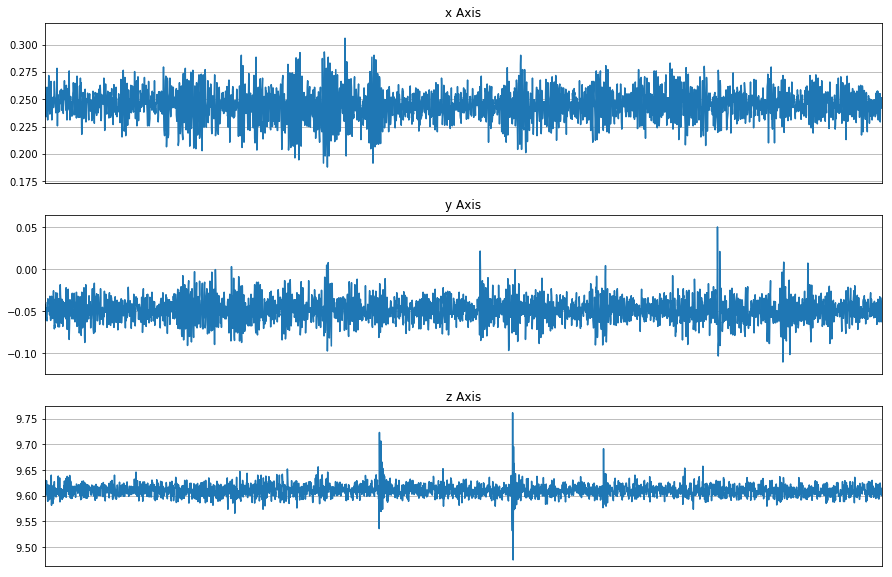

In [6]:
plot_activity(STANDING)

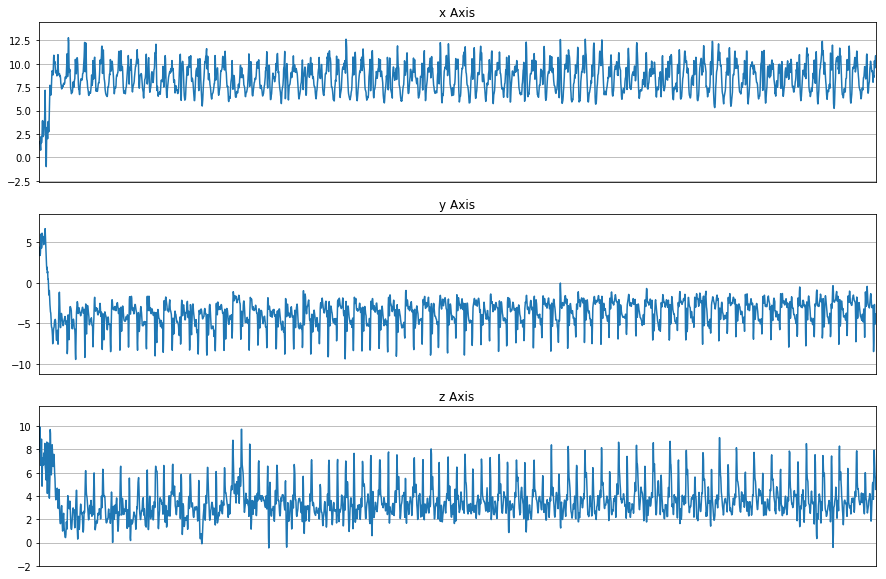

In [7]:
plot_activity(WALKING)

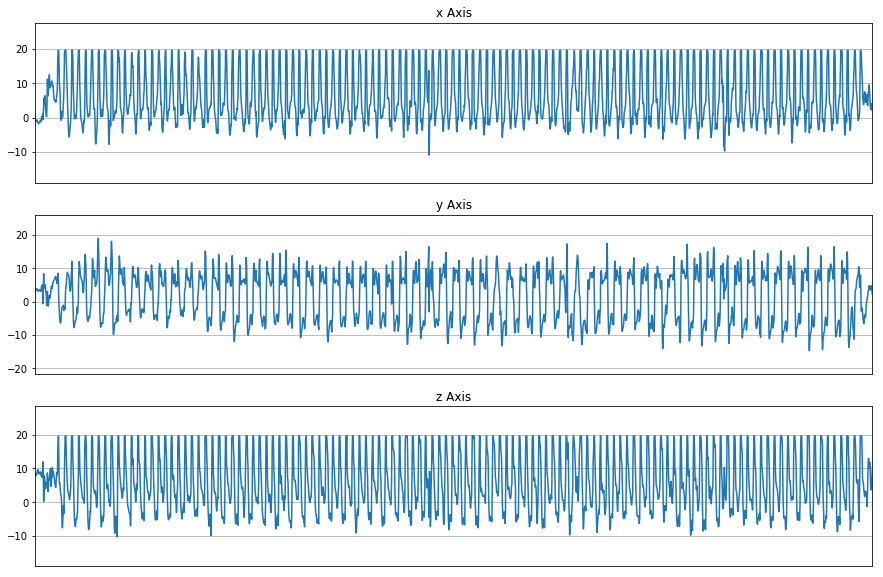

In [8]:
plot_activity(RUNNING)

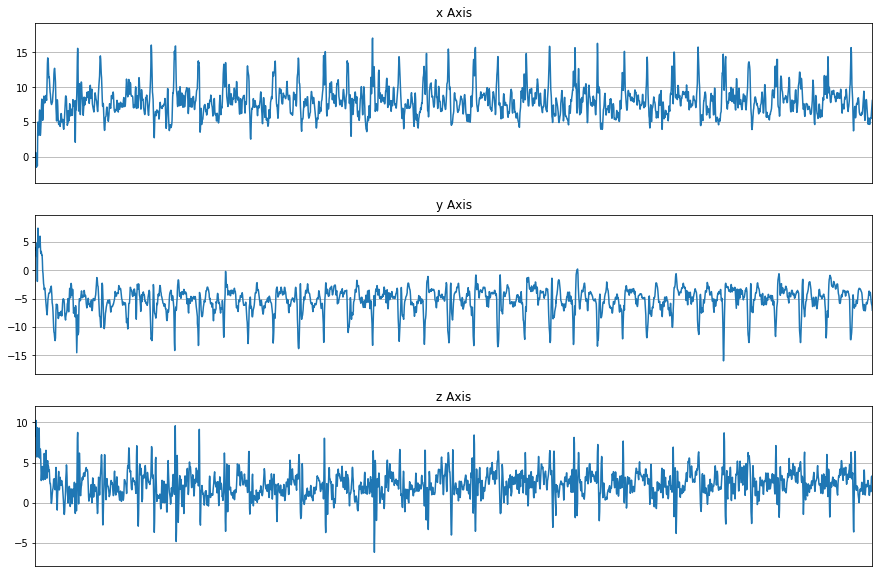

In [9]:
plot_activity(STAIRS)

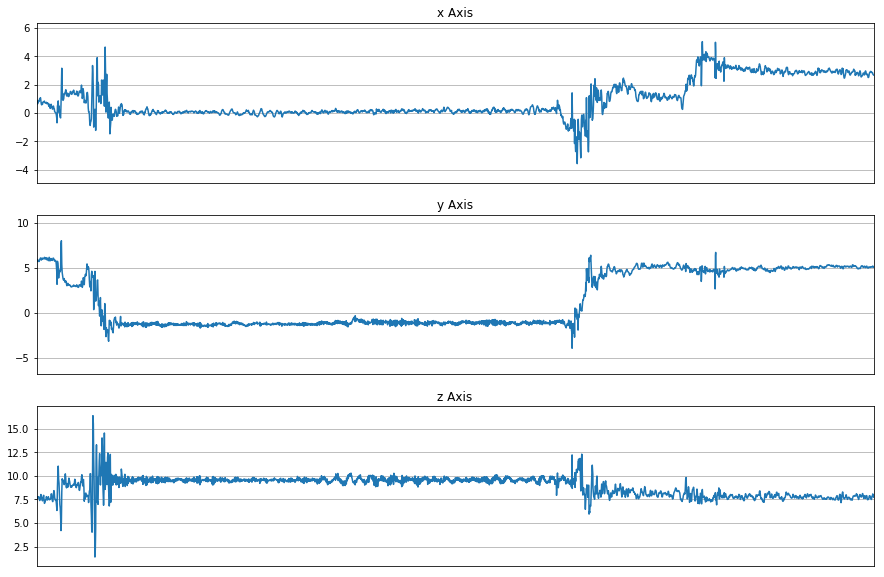

In [10]:
plot_activity(ON_TRAIN)

In [11]:
import math

def magnitude(activity):
    x2 = activity['xAxis'] * activity['xAxis']
    y2 = activity['yAxis'] * activity['yAxis']
    z2 = activity['zAxis'] * activity['zAxis']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

In [12]:
STANDING['magnitude'] = magnitude(STANDING)
WALKING['magnitude'] = magnitude(WALKING)
RUNNING['magnitude'] = magnitude(RUNNING)
STAIRS['magnitude'] = magnitude(STAIRS)
ON_TRAIN['magnitude'] = magnitude(ON_TRAIN)

In [13]:
def plot_magnitudes(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(15, 15))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['magnitude'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()


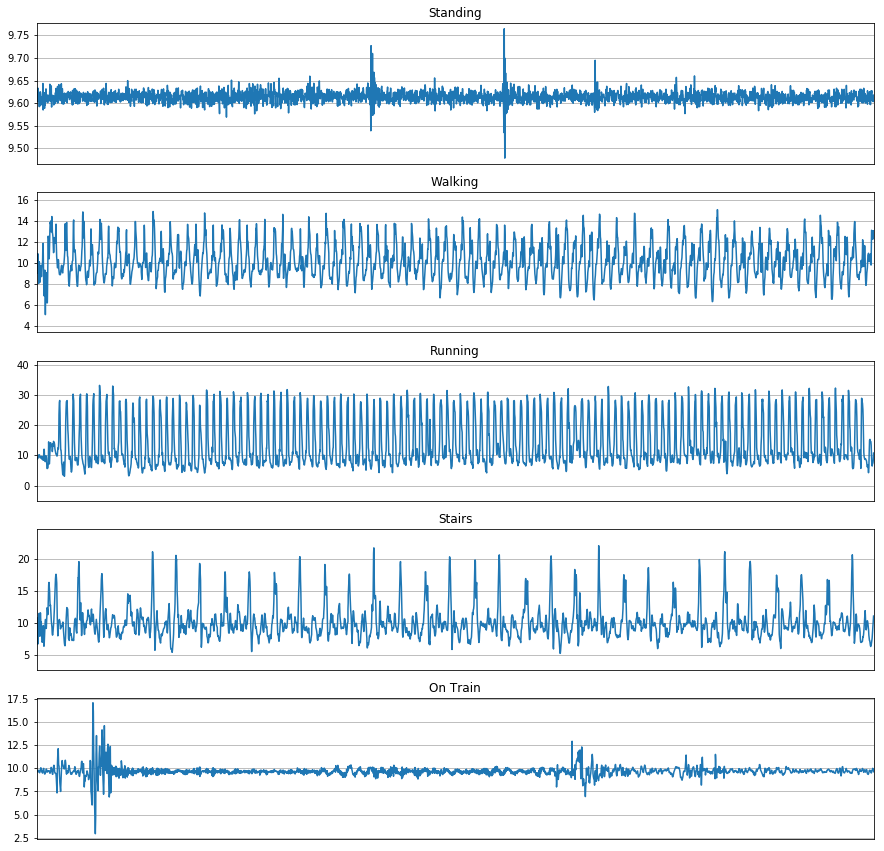

In [14]:
plot_magnitudes([STANDING, WALKING, RUNNING, STAIRS, ON_TRAIN],
               ['Standing', 'Walking', 'Running', 'Stairs', 'On Train'])

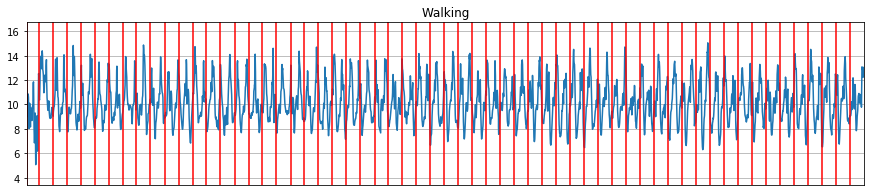

In [85]:
def windows(df, size=100):
    start = 0
    while start < df.count():
        yield start, int(start + size)
        start += int(size / 2)

fig, ax = plt.subplots(nrows=1, figsize=(15, 3))
plot_axis(ax, WALKING['timestamp'], WALKING['magnitude'], 'Walking')

for (start, end) in windows(WALKING['timestamp']):
    ax.axvline(WALKING['timestamp'][start], color='r')
    
plt.show()

In [88]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import numpy as np
import math

def jitter(axis, start, end):
    j = float(0)
    for i in range(start, min(end, axis.count())):
        if start != 0:
            j += abs(axis[i] - axis[i-1])
    return j / (end-start)

def mean_crossing_rate(axis, start, end):
    cr = 0
    m = axis.mean()
    for i in range(start, min(end, axis.count())):
        if start != 0:
            p = axis[i-1] > m
            c = axis[i] > m
            if p != c:
                cr += 1
    return float(cr) / (end-start-1)

def window_summary(axis, start, end):
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        jitter(axis, start, end),     
        mean_crossing_rate(axis, start, end),
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

def features(activity):
    for (start, end) in windows(activity['timestamp']):
        features = []
        for axis in ['xAxis', 'yAxis', 'zAxis', 'magnitude']:
            features += window_summary(activity[axis], start, end)
        yield features

In [89]:
import csv

activities = [STANDING, WALKING, RUNNING, STAIRS, ON_TRAIN]

with open('data/Features.csv', 'w') as out:
    rows = csv.writer(out)
    for i in range(0, len(activities)):
        for f in features(activities[i]):
            rows.writerow([i] + f)

In [90]:
dataset = np.loadtxt('data/Features.csv', delimiter=",")
X = dataset[:, 1:]
y = dataset[:, 0]

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cross_validation import train_test_split

c = RandomForestClassifier()
b = DummyClassifier() # generates predictions by respecting the training set's class distribution

results = []
baselines = []

for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    c.fit(X_train, y_train)
    b.fit(X_train, y_train)
    res = c.score(X_test, y_test)
    bas = b.score(X_test, y_test)
    print('Loop', i, res, bas)
    results.append(res)
    baselines.append(bas)

print('\nBaseline', np.mean(baselines), np.std(baselines))
print('Random Forest', np.mean(results), np.std(results))



/Users/ganesh/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loop 0 0.983333333333 0.108333333333
Loop 1 0.991666666667 0.291666666667
Loop 2 1.0 0.183333333333
Loop 3 0.991666666667 0.216666666667
Loop 4 0.933333333333 0.158333333333
Loop 5 0.95 0.158333333333
Loop 6 0.991666666667 0.141666666667
Loop 7 0.975 0.216666666667
Loop 8 1.0 0.2
Loop 9 1.0 0.2

Baseline 0.1875 0.0479076078393
Random Forest 0.981666666667 0.0216666666667
